In [1]:
%matplotlib inline
#! switch_R 3.3
%load_ext rpy2.ipython

In [2]:
import math
import numpy as np
import pandas as pd
import pickle
import pygam
from pyspan.config import *
from pyspan.ratings_task.analysis import freq_df, n_utterances, SparseLR
from pyspan.utils import *

/Users/sabinasloman/Box/LoP/pyspan/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  

In [3]:
signals = pickle.load(open(paths["metrics_dir"] + "signals-unigrams"))
words = pd.read_csv("{}synonyms.csv".format(paths["synonyms_task_path"]))
words = words.loc[range(7) + range(8,26)][["D","R"]]
words = np.ravel(words)
signals = dict(zip(words, 
                   map(lambda w: signals.loc[w]["rmetric"], words)))
valence_data = pd.read_csv("valence_data.csv")
valences = dict(zip(np.ravel(valence_data[["D","R"]]), 
                    np.ravel(valence_data[["D_valence","R_valence"]]))
               )

In [4]:
df = pd.read_csv("responses.csv")
df.rename(columns = { "1": 1, "2": 2, "3": 3, "4": 4, "5": 5 },
          inplace = True)
df.replace({ "1": 1, "2": 2, "3": 3, "4": 4, "5": 5 }, inplace = True)

In [5]:
list_party_cols = map(lambda i: "list{}_party".format(i), range(1,6))
list_cols = map(lambda i: "list{}".format(i), range(1,6))

In [6]:
# Some demographics
print np.mean(df.age[~np.isnan(df.age)]), stats.sem(df.age[~np.isnan(df.age)])
print len(df.loc[df.gender == 2]), len(df.loc[df.gender == 1])
voted = df.voted.values
voted[voted == 2] = 0
print np.mean(voted)

35.811764705882354 0.8264673367019187
102 66
0.788235294117647


In [7]:
dmask = np.ma.masked_where(df[list_party_cols] == "democrat", 
                           df[range(1,6)])
ddat = dmask.data[dmask.mask]
rmask = np.ma.masked_where(df[list_party_cols] == "republican", 
                           df[range(1,6)])
rdat = rmask.data[rmask.mask]

In [8]:
np.mean(rdat[~np.isnan(rdat)]), stats.sem(rdat[~np.isnan(rdat)])

(3.9569377990430623, 0.0693050521522237)

In [9]:
np.mean(ddat[~np.isnan(ddat)]), stats.sem(ddat[~np.isnan(ddat)])

(3.5416666666666665, 0.0668167458693751)

In [10]:
np.mean(rdat[~np.isnan(rdat)]) - np.mean(ddat[~np.isnan(ddat)])

0.4152711323763958

In [11]:
ddat_ = dmask.data.copy().astype("float")
ddat_[~dmask.mask] = np.nan
rdat_ = rmask.data.copy().astype("float")
rdat_[~rmask.mask] = np.nan

Analysis of variance

In [12]:
%%R -i ddat_,rdat_
# https://www.r-bloggers.com/how-to-do-repeated-measures-anovas-in-r/
y <- c(t(ddat_), t(rdat_))
n <- dim(ddat_)[1]
stopifnot(n == dim(rdat_)[1])
kd <- dim(ddat_)[2]
kr <- dim(rdat_)[2]
clusters <- c(rep(1:n, each = kd), rep(1:n, each = kr))
groups <- c(rep(0, n*kd), rep(1, n*kr))
fit <- aov(y ~ groups + Error(clusters/groups))
summary(fit)

library(lmerTest)
fit <- lmer(y ~ groups + (1|clusters))
anova(fit)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘lmerTest’


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmer


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is

Type III Analysis of Variance Table with Satterthwaite's method
       Sum Sq Mean Sq NumDF DenDF F value    Pr(>F)    
groups 36.636  36.636     1   848   18.62 1.783e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Compute an individual-level effect size and test the hypothesis that it's greater than 0.

In [13]:
def participant_diff(i):
    djudgments = dmask.data[i,dmask.mask[i,:]]
    djudgments = djudgments[~np.isnan(djudgments)]
    rjudgments = rmask.data[i,rmask.mask[i,:]]
    rjudgments = rjudgments[~np.isnan(rjudgments)]
    return cohensd(rjudgments, djudgments)
    
participant_diff = np.vectorize(participant_diff)

In [14]:
pdiffs = participant_diff(np.arange(len(df)))

/Users/sabinasloman/Box/LoP/pyspan/pyspan/utils.py:221: RuntimeWarning: invalid value encountered in double_scalars
  return diff / spooled


(0.43631199740173376, 0.09383669882152874)

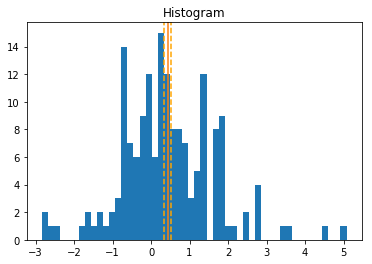

In [15]:
fig, mu, sig = histogram(pdiffs[~is_nan(pdiffs)])
mu, sig

In [16]:
t, p = stats.ttest_1samp(pdiffs[~is_nan(pdiffs)], 0)
t, p / 2

(4.6496946597788, 3.34895531281201e-06)

In [17]:
len(pdiffs[~is_nan(pdiffs)]) - 1

168

A logistic regression where the unit of observation is the likelihood judgment of a group of five words. In particular, we will estimate the model, including participant-level effects:

REPUBLICAN ~ Sum(log odds that each word was spoken by a Republican) + Sum(valence of words) + Participant's party identity + Sum(valence of words) * Participant's party identity

where "REPUBLICAN" corresponds to a rating >= 3, or a judgment that the list of words was "more likely to have been spoken by a Republican".

In [18]:
lr_data = df.copy()
lr_data = lr_data.loc[lr_data.party.isin([ 1,2 ])]

n = len(lr_data)
# Add dummy columns
for i in range(1, n):
    ids = np.zeros(n)
    ids[i] = 1
    lr_data["participant{}".format(i)] = ids

In [19]:
Y_full = np.ravel(lr_data[range(1,6)])
Y = Y_full > 2.5
X = np.full((n * 5, 4 + n - 1), np.nan)
# Sum(log odds that each word was spoken by a Republican)
vf = np.vectorize(lambda l: sum(map(lambda w: signals[w], 
                                    l.split(", "))))
X[:,0] = vf(np.ravel(lr_data[list_cols]))
# Sum(valence of words)
vf = np.vectorize(lambda l: sum(map(lambda w: valences[w] - 5, 
                                    l.split(", "))))
X[:,1] = vf(np.ravel(lr_data[list_cols]))
# Participant's political identity
vf = np.vectorize(lambda pid: int(pid == 1))
pids = np.repeat(vf(lr_data.party), 5)
pids[pids == 0] = -1
X[:,2] = pids
# Valence of word * Participant's party identity
X[:,3] = X[:,1] * X[:,2]
for i in range(4, 4 + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-3)], 5)

In [20]:
Y = Y[~np.isnan(Y_full)]
X = X[~np.isnan(Y_full)]
Y_full = Y_full[~np.isnan(Y_full)]
X = X[~np.isnan(Y)]
Y_full = Y_full[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
Y_full = Y_full[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]

In [21]:
# Get a dataframe where the signal indicator is binarized
X_binary = X.copy()
X_binary[:,0] = [ x > 0 for x in X_binary[:,0] ]

In [22]:
logit = SparseLR(Y, X); logit.coef[:4], logit.auc

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


(array([ 0.17635601, -0.06193283, -0.10149069,  0.05907212]),
 0.8141810101814082)

In [23]:
logit = SparseLR(Y, X_binary); logit.coef[:4], logit.auc

(array([ 0.7713158 , -0.0720449 , -0.09889211,  0.05852694]),
 0.8157231452923424)

Logistic GAM

In [24]:
logistic_gam = pygam.LogisticGAM(pygam.terms.TermList(*[pygam.s(0), pygam.s(1), 
                                 pygam.f(2), pygam.s(3)] + 
                                 [pygam.f(i) for i in range(4, X.shape[1])]))
logistic_gam.fit(X, Y)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38) + f(39) + f(40) + f(41) + f(42) + f(43) + f(44) + f(45) + f(46) + f(47) + f(48) + f(49) + f(50) + f(51) + f(52) + f(53) + f(54) + f(55) + f(56) + f(57) + f(58) + f(59) + f(60) + f(61) + f(62) + f(63) + f(64) + f(65) + f(66) + f(67) + f(68) + f(69) + f(70) + f(71) + f(72) + f(73) + f(74) + f(75) + f(76) + f(77) + f(78) + f(79) + f(80) + f(81) + f(82) + f(83) + f(84) + f(85) + f(86) + f(87) + f(88) + f(89) + f(90) + f(91) + f(92) + f(93) + f(94) + f(95) + f(96) + f(97) + f(98) + f(99) + f(100) + f(101) + f(102) + f(103) + f(104) + f(105) + f(106) + f(107) + f(108) + f(109) + f(110) + f(111)

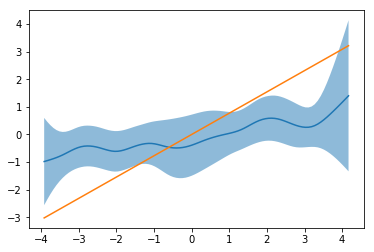

In [25]:
plot_prf(logistic_gam, 0, logit.coef[0])

Linear model

Same as the LR, but a linear model of the full ratings scale

In [26]:
lm = sm.OLS(Y_full, sm.add_constant(X))
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.128
Date:                Thu, 30 Apr 2020   Prob (F-statistic):              0.194
Time:                        14:57:09   Log-Likelihood:                -958.40
No. Observations:                 575   AIC:                             2153.
Df Residuals:                     457   BIC:                             2667.
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0101      0.335     11.971      0.000       3.352       4.668
x1             0.1444      0.029      4.906      0.000       0.087       0.202
x2            -0.0501      0.019     -2.572      0.010      -0.088      -0.012
x3            -0.1228      0.335     -0.367      0.714      -0.780       0.535
x4             0.0303      0.019      1.599      0.111      -0.007       0.068
x5            -0.1446      0.909     -0.159      0.874      -1.932       1.642
x6             0.0284      0.909      0.031      0.975      -1.758       1.815
x7             1.3104      0.634      2.066      0.039       0.064       2.557
x8            -0.0333      0.909     -0.037      0.971      -1.820       1.753
x9             0.2786      0.909      0.306      0.759      -1.508       2.065
x10           -0.4145      0.909     -0.456      0.649      -2.201       1.372
x11           -0.0563      0.634     -0.089      0.929      -1.303       1.190
x12           -0.2071      0.635     -0.326      0.744      -1.455       1.041
x13            0.3575      0.910      0.393      0.695      -1.430       2.145
x14           -0.5682      0.909     -0.625      0.532      -2.355       1.218
x15            0.5127      0.634      0.808      0.419      -0.734       1.760
x16           -0.1811      0.909     -0.199      0.842      -1.968       1.606
x17           -0.0752      0.635     -0.118      0.906      -1.323       1.172
x18           -0.6158      0.909     -0.678      0.498      -2.402       1.170
x19            0.5404      0.909      0.595      0.552      -1.246       2.327
x20            0.0389      0.909      0.043      0.966      -1.747       1.825
x21            0.1140      0.634      0.180      0.858      -1.133       1.361
x22            0.0663      0.909      0.073      0.942      -1.720       1.853
x23            0.6534      0.634      1.030      0.303      -0.593       1.900
x24           -1.1222      0.909     -1.234      0.218      -2.909       0.665
x25           -0.5663      0.634     -0.893      0.372      -1.812       0.680
x26           -0.0228      0.635     -0.036      0.971      -1.270       1.225
x27           -0.7595      0.909     -0.836      0.404      -2.546       1.027
x28            0.9948      0.634      1.569      0.117      -0.251       2.241
x29            0.4529      0.909      0.498      0.619      -1.334       2.240
x30            0.6425      0.909      0.707      0.480      -1.145       2.430
x31            0.3083      0.635      0.486      0.627      -0.939       1.556
x32           -0.1669      0.910     -0.183      0.855      -1.955       1.621
x33            0.0069      0.634      0.011      0.991      -1.239       1.253
x34            0.2662      0.909      0.293      0.770      -1.520       2.053
x35            0.1605      0.634      0.253      0.800      -1.085       1.406
x3

In [27]:
lm = sm.OLS(Y_full, sm.add_constant(X_binary))
res_binary = lm.fit()
res_binary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.112
Date:                Thu, 30 Apr 2020   Prob (F-statistic):              0.224
Time:                        14:57:12   Log-Likelihood:                -959.36
No. Observations:                 575   AIC:                             2155.
Df Residuals:                     457   BIC:                             2669.
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7013      0.338     10.939      0.000       3.036       4.366
x1             0.6140      0.130      4.739      0.000       0.359       0.869
x2            -0.0576      0.020     -2.879      0.004      -0.097      -0.018
x3            -0.1067      0.335     -0.319      0.750      -0.765       0.552
x4             0.0303      0.019      1.595      0.111      -0.007       0.068
x5            -0.0415      0.911     -0.046      0.964      -1.831       1.748
x6             0.0663      0.911      0.073      0.942      -1.724       1.856
x7             1.3458      0.635      2.119      0.035       0.098       2.594
x8             0.0358      0.911      0.039      0.969      -1.754       1.826
x9             0.3191      0.911      0.350      0.726      -1.471       2.109
x10           -0.3402      0.911     -0.373      0.709      -2.130       1.450
x11           -0.0466      0.635     -0.073      0.942      -1.295       1.202
x12           -0.2233      0.636     -0.351      0.726      -1.473       1.027
x13            0.3754      0.911      0.412      0.681      -1.416       2.166
x14           -0.5258      0.911     -0.577      0.564      -2.316       1.264
x15            0.4609      0.635      0.726      0.469      -0.787       1.709
x16           -0.1694      0.911     -0.186      0.853      -1.960       1.621
x17           -0.1171      0.636     -0.184      0.854      -1.366       1.132
x18           -0.5871      0.910     -0.645      0.519      -2.376       1.202
x19            0.5864      0.910      0.644      0.520      -1.203       2.376
x20            0.0454      0.911      0.050      0.960      -1.744       1.835
x21            0.0619      0.635      0.097      0.922      -1.186       1.310
x22            0.0912      0.911      0.100      0.920      -1.699       1.881
x23            0.6666      0.635      1.049      0.295      -0.582       1.915
x24           -1.0646      0.911     -1.169      0.243      -2.854       0.725
x25           -0.5376      0.635     -0.846      0.398      -1.786       0.711
x26           -0.0287      0.636     -0.045      0.964      -1.278       1.221
x27           -0.6820      0.911     -0.749      0.454      -2.472       1.108
x28            1.0586      0.635      1.666      0.096      -0.190       2.307
x29            0.4826      0.911      0.530      0.597      -1.307       2.272
x30            0.7192      0.911      0.790      0.430      -1.070       2.509
x31            0.2486      0.636      0.391      0.696      -1.000       1.497
x32           -0.1360      0.911     -0.149      0.881      -1.926       1.655
x33           -0.0435      0.635     -0.069      0.945      -1.292       1.205
x34            0.2636      0.911      0.290      0.772      -1.526       2.053
x35            0.1429      0.635      0.225      0.822      -1.105       1.391
x3

Linear GAM

In [28]:
linear_gam = pygam.LinearGAM(pygam.terms.TermList(*[pygam.s(0), 
                             pygam.s(1), pygam.f(2), pygam.s(3)] + 
                             [pygam.f(i) for i in range(4, X.shape[1])]))
linear_gam.fit(X, Y_full)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38) + f(39) + f(40) + f(41) + f(42) + f(43) + f(44) + f(45) + f(46) + f(47) + f(48) + f(49) + f(50) + f(51) + f(52) + f(53) + f(54) + f(55) + f(56) + f(57) + f(58) + f(59) + f(60) + f(61) + f(62) + f(63) + f(64) + f(65) + f(66) + f(67) + f(68) + f(69) + f(70) + f(71) + f(72) + f(73) + f(74) + f(75) + f(76) + f(77) + f(78) + f(79) + f(80) + f(81) + f(82) + f(83) + f(84) + f(85) + f(86) + f(87) + f(88) + f(89) + f(90) + f(91) + f(92) + f(93) + f(94) + f(95) + f(96) + f(97) + f(98) + f(99) + f(100) + f(101) + f(102) + f(103) + f(104) + f(105) + f(106) + f(107) + f(108) + f(109) + f(110) + f(111) +

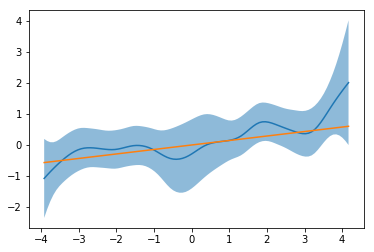

In [29]:
plot_prf(linear_gam, 0, res.params[1])

Appendix: Analysis of hypothesized mediators

$accurate \sim logodds + log(P) + party\_id + valence + party\_id \times valence \times sign(word) + party\_identity + party\_id \times party\_identity + political\_engagement + party\_id \times political\_engagement + \ldots{}$

In [30]:
lr_data = df.copy()
lr_data = lr_data.loc[lr_data.party.isin([ 1,2 ])]

n = len(lr_data)
# Add dummy columns
for i in range(1, n):
    ids = np.zeros(n)
    ids[i] = 1
    lr_data["participant{}".format(i)] = ids

n_vars = 9
    
Y_full = np.ravel(lr_data[range(1,6)])
Y = Y_full > 2.5
X = np.full((n * 5, n_vars + n - 1), np.nan)
# Sum(log odds that each word was spoken by a Republican)
vf = np.vectorize(lambda l: sum(map(lambda w: signals[w], 
                                    l.split(", "))))
s = vf(np.ravel(lr_data[list_cols]))
X[:,0] = np.abs(s)
# Sum(log(P) of each word)
calc_mP = lambda word: math.log(sum(freq_df.loc[(word,["dmetric","rmetric"])].values) / 
                                n_utterances, 2)
vf = np.vectorize(lambda l: sum(map(calc_mP, l.split(", "))))
X[:,1] = vf(np.ravel(lr_data[list_cols]))
# Participant's political identity
vf = np.vectorize(lambda pid: 1 if pid == 1 else -1)
pids = np.repeat(vf(lr_data.party), 5)
X[:,2] = pids
# Valence of word
# Sum(valence of words)
vf = np.vectorize(lambda l: sum(map(lambda w: valences[w] - 5, 
                                    l.split(", "))))
X[:,3] = vf(np.ravel(lr_data[list_cols]))
# Valence of word * Participant's party identity * Word is Republican
X[:,4] = pids * X[:,3] * np.sign(s) 
# Party identity
X[:,5] = np.repeat(lr_data.party_identity, 5)
# Party affiliation x party identity
X[:,6] = pids * X[:,5]
# Political engagement
X[:,7] = np.repeat(lr_data.political_engagement, 5)
# Party affiliation x political engagement
X[:,8] = pids * X[:,7]
# Participant IDs
for i in range(n_vars, n_vars + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-n_vars+1)], 5)

polarity = s > 0
Y = (Y & polarity) | (~Y & ~polarity)

X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]
X = stats.mstats.zscore(X)

In [31]:
logit = SparseLR(Y, X); logit.coef[:8], logit.n, logit.auc

(array([ 0.        , -0.15730473,  0.        ,  0.0384301 ,  0.        ,
         0.        ,  0.        ,  0.        ]), 575, 0.6160183289460855)